In [1]:
import full_nuclide_ap21
import full_nuclide_ap21_r
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pynucastro as pyna

In [2]:
def plot(tmin, tmax, sol, network, outfile='test'):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    for i in range(network.nnuc):
        ax.loglog(sol.t, sol.y[i,:] * network.A[i], label=f"X({network.names[i].capitalize()})")

    ax.set_xlim(tmin, tmax)
    ax.set_ylim(1.e-10, 1.0)
    ax.legend(fontsize="small")

    fig.set_size_inches((10, 8))
    fig.savefig(outfile)

def composition(network):
    
    X0 = np.zeros(network.nnuc)
    X0[network.jco55] = 0.0
    X0[network.jn] = 3.0
    X0[network.jcr48] = 1.0
    X0[network.jfe52] = 0.0
    X0[network.jhe4] = 3.0
    X0[network.jmn51] = 0.0
    X0[network.jni56] = 0.0
    X0[network.jcr56] = 0.0
    X0[network.jfe54] = 0.0
    X0[network.jfe55] = 0.0
    X0[network.jfe56] = 0.0
    X0[network.jmn56] = 0.0
    X0[network.jp] = 3.0
    X0[network.jfe53] = 0.0
    X0[network.jmn52] = 0.0
    X0[network.jco56] = 0.0
    
    X0 /= np.sum(X0)
    Y0 = X0/network.A

    return Y0

def plot_ye(tmin, tmax, sol, network, outfile='test'):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    y_e = np.zeros_like(sol.t)
    for i in range(network.nnuc):
        y_e += sol.y[i,:] * network.Z[i]

    ax.plot(sol.t, y_e, label=r"$Y_e$")
    ax.set_xscale('log')


    ax.set_xlim(tmin, tmax)
    ax.set_ylim(0.0, 1.0)
    ax.legend(fontsize="small")

    fig.set_size_inches((10, 8))
    fig.savefig(outfile)

    

In [3]:
# X0 = np.zeros(full_nuclide_ap21.nnuc)
# X0[full_nuclide_ap21.jco55] = 2.482511070588218e-65
# X0[full_nuclide_ap21.jn] = 0.47178705676692634
# X0[full_nuclide_ap21.jcr48] = 7.133393741449612e-59
# X0[full_nuclide_ap21.jfe52] = 3.354608548684804e-63
# X0[full_nuclide_ap21.jhe4] = 0.01410647161653639
# X0[full_nuclide_ap21.jmn51] = 6.78849203380635e-61
# X0[full_nuclide_ap21.jni56] = 9.055614734814937e-68
# X0[full_nuclide_ap21.jcr56] = 4.347040372730703e-64
# X0[full_nuclide_ap21.jfe54] = 3.8684763612138994e-61
# X0[full_nuclide_ap21.jfe55] = 6.254296779924982e-62
# X0[full_nuclide_ap21.jfe56] = 2.271437642048365e-61
# X0[full_nuclide_ap21.jmn56] = 5.325706015205362e-63
# X0[full_nuclide_ap21.jp] = 0.4717870567669292
    
# X0 /= sum(X0)
# Y0 = X0/full_nuclide_ap21.A


In [4]:
Y0 = composition(full_nuclide_ap21)
rho = 2.0e4
T = 7.0e9
ye = full_nuclide_ap21.ye(Y0)

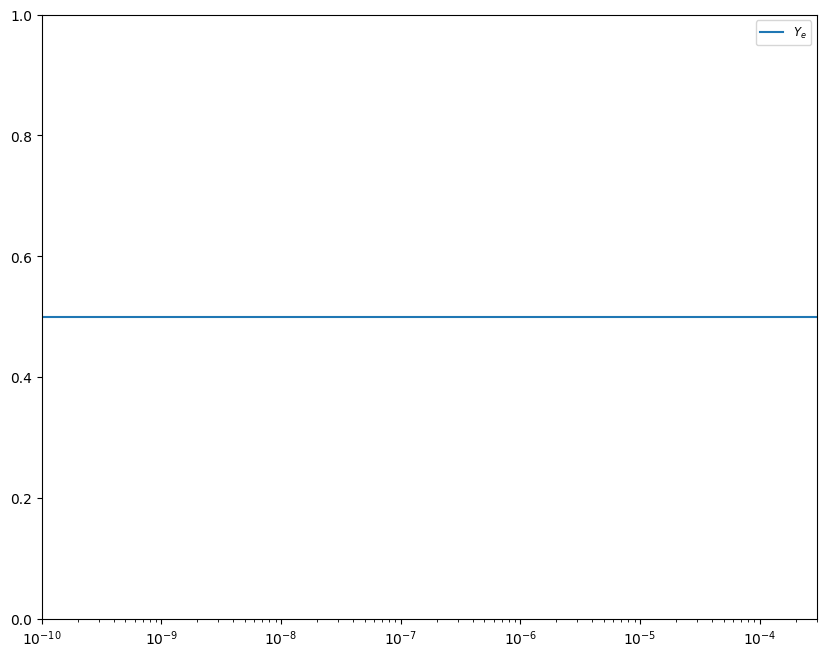

In [5]:
# tmax = 1.0e4
# tmin = 1.0e-1

tmax = 3.0e-4
tmin = 1.0e-10

sol =  solve_ivp(full_nuclide_ap21.rhs, [0, tmax], Y0, method="BDF",
                dense_output=True, args=(rho, T), rtol=1.e-9, atol=1.e-9, jac=full_nuclide_ap21.jacobian)

plot_ye(tmin=tmin, tmax=tmax, sol=sol, network=full_nuclide_ap21, outfile='rho_{:.2e}_T_{:.2e}_ye_{:.2e}.png'.format(rho,T, ye))

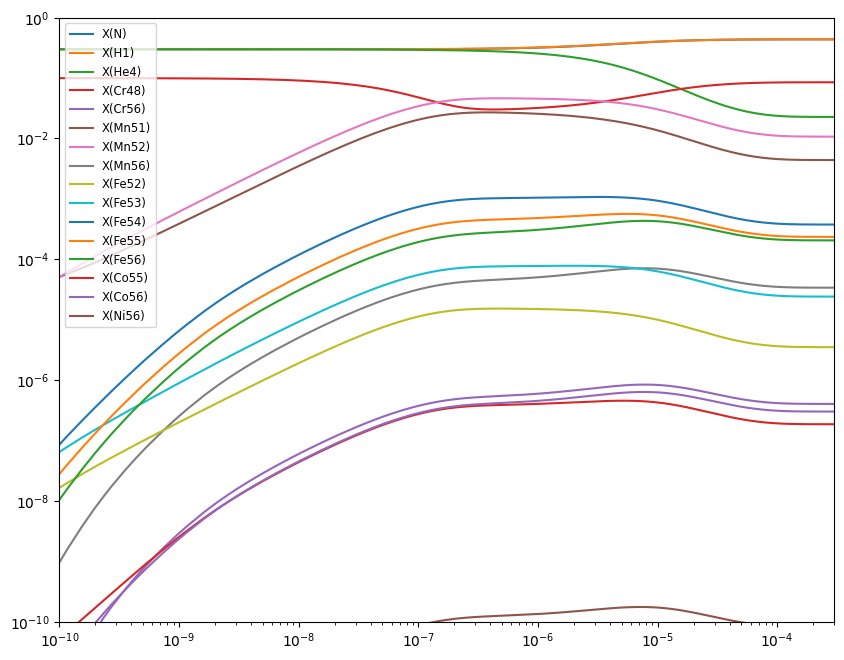

In [6]:
plot(tmin=tmin, tmax=tmax, sol=sol, network=full_nuclide_ap21, outfile='rho_{:.2e}_T_{:.2e}.png'.format(rho,T))

In [7]:
# tmax = 1.0e-2
# tmin = 1.0e-11

# sol_r = solve_ivp(full_nuclide_ap21_r.rhs, [0, tmax], Y0_r, method="BDF",
#                 dense_output=True, args=(rho, T), rtol=1.e-8, atol=1.e-8, jac=full_nuclide_ap21_r.jacobian)

# # sol_r = solve_ivp(full_nuclide_ap21_r.rhs, [0, tmax], Y0_r, method="BDF",
# #                 dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-6)

# plot(tmin=tmin, tmax=tmax, sol=sol_r, network=full_nuclide_ap21_r, outfile='rho_{:.2e}_T_{:.2e}_r.png'.format(rho,T))

# Chhecking the NSE state

In [8]:
# Find NSE composition to compare with integration route:

all_reactions = pyna.ReacLibLibrary()
fwd_reactions = all_reactions.derived_forward()

all_nuclei = ['cr48', 'mn51', 'fe52', 'ni56', 'p', 'n', 'he4', 'co55',
              'fe54','fe55', 'fe54', 'fe56', 'cr56', 'mn56', 'fe53', 'mn52', 'co56']

fwd_rates_lib = fwd_reactions.linking_nuclei(nuclist=all_nuclei, with_reverse=False)

derived = []
for r in fwd_rates_lib.get_rates():
    d = pyna.rates.DerivedRate(rate=r, compute_Q=False, use_pf=True)
    derived.append(d)

der_rates_lib = pyna.Library(rates=derived)
full_library = fwd_rates_lib + der_rates_lib

# full_library.remove_rate(rate="fe55 + p --> n + co55 <derived_reaclib__>")
# full_library.remove_rate(rate="co55 + n --> p + fe55 <ths8_reaclib__>")
# full_library.remove_rate(rate="mn51 + he4 --> co55 <ths8_reaclib__>")
# full_library.remove_rate(rate="co55 --> he4 + mn51 <derived_reaclib__>")

weak_rates = []
weak_rates.append(all_reactions.get_rate("n --> p <wc12_reaclib_weak_>"))
weak_rates.append(all_reactions.get_rate("co55 --> fe55 <wc12_reaclib_weak_>"))
weak_rates.append(all_reactions.get_rate("cr56 --> mn56 <wc12_reaclib_weak_>"))
weak_rates.append(all_reactions.get_rate("mn56 --> fe56 <wc12_reaclib_weak_>"))
weak_lib = pyna.Library(rates=weak_rates)
full_library += weak_lib

rc = pyna.RateCollection(libraries=full_library)

In [9]:
comp = rc.get_comp_NSE(rho, T, ye)

print("From NSE calculation:")
print(comp)

print("From integration:")
for i in range(full_nuclide_ap21.nnuc):
    print(f"X({full_nuclide_ap21.names[i]}): {sol.y[i,-1] * full_nuclide_ap21.A[i]}")

From NSE calculation:
  X(n) : 0.3922034457812337
  X(p) : 0.3922034457817127
  X(he4) : 0.2155931083590536
  X(cr48) : 6.842100663976664e-47
  X(cr56) : 2.8405128253224653e-50
  X(mn51) : 3.182291905377822e-48
  X(mn52) : 6.276896747685783e-48
  X(mn56) : 3.482880984403479e-49
  X(fe52) : 2.6681767779631006e-50
  X(fe53) : 4.037121559427705e-50
  X(fe54) : 8.832707958028737e-48
  X(fe55) : 2.4182250614845958e-48
  X(fe56) : 1.4867562290162332e-47
  X(co55) : 9.607405833830706e-52
  X(ni56) : 5.938401631949456e-54

From integration:
X(n): 0.4377679931852063
X(h1): 0.43831258006151
X(he4): 0.022727257525944435
X(cr48): 0.08519200926360868
X(cr56): 4.0270758559855796e-07
X(mn51): 0.004395778696385863
X(mn52): 0.010725465047185405
X(mn56): 3.385924280310029e-05
X(fe52): 3.5106856601061567e-06
X(fe53): 2.4096211760712543e-05
X(fe54): 0.0003760139029119308
X(fe55): 0.00023490242608855967
X(fe56): 0.00020564423024881264
X(co55): 1.857170888205989e-07
X(co56): 3.010133693886466e-07
X(ni56): 8

/home/alex/anaconda3/envs/work/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


ValueError: shape mismatch: objects cannot be broadcast to a single shape

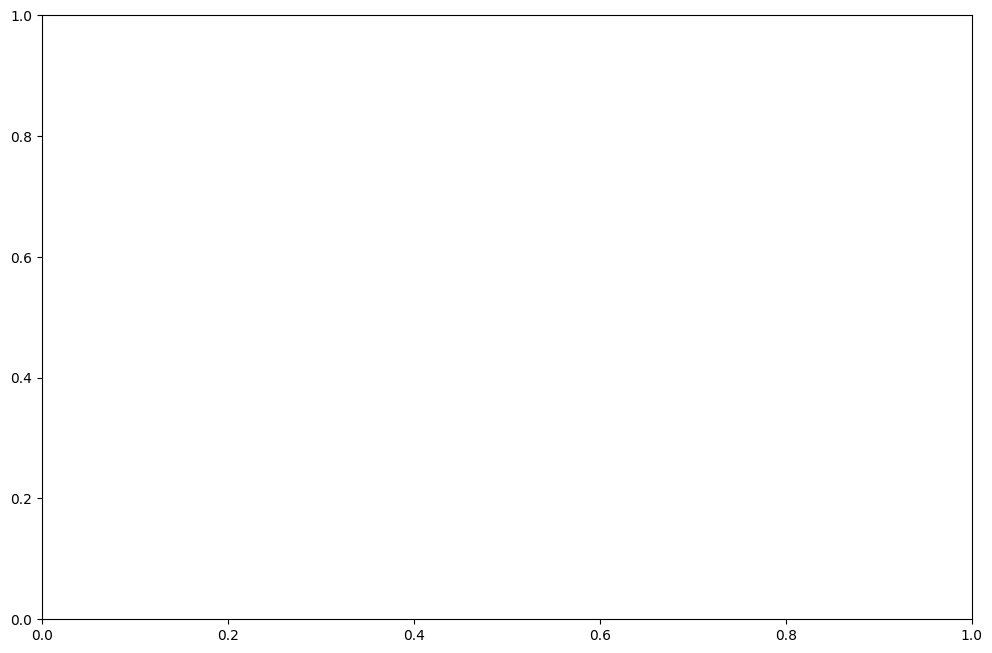

In [11]:
# Bar graph for visual

x = np.arange(len(full_nuclide_ap21.names))
width = 0.35

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.bar(x - width/2.0, list(comp.X.values()), width, label = 'NSE')
ax.bar(x + width/2.0, sol.y[:,-1]*full_nuclide_ap21.A, width, label = 'Integration')
ax.set_xlabel("Nuclei")
ax.set_xticks(x, full_nuclide_ap21.names)
ax.set_ylabel("Mass Fractions")
ax.set_yscale("log")
ax.set_title("NSE vs. Integration")
ax.set_ylim(ymax = 1)
ax.legend()